In [339]:
from flickplay.get_connections import get_alchemy_con, get_pymysql_con
from flickplay.mongo import get_mongo_db_obj
import pandas as pd
import warnings
import numpy as np
import sys

warnings.filterwarnings("ignore")

con, conp = get_alchemy_con(), get_pymysql_con()
db = get_mongo_db_obj()

In [340]:

conp = get_pymysql_con()

query = """
SELECT event, $user_id, date, time
FROM fpa.events
WHERE 
    event like 'session%' AND
--    event='session__start' OR 
--    event='session__end' AND
    date>='2022-12-1' AND
--    date<'2022-12-1' AND
    $user_id IS NOT NULL
ORDER BY time asc
"""

dd = pd.read_sql(query, conp).dropna()


In [341]:
uids = list(set(dd['$user_id']))
pd.set_option('display.max_rows', None)


avg_session_length_by_user, n_sessions_by_user = dict(), dict()

for idx, uid in enumerate(uids):
    sys.stdout.write(f'\r{idx} of {nuids}.')
    lengths = []
    user_dd = dd[dd['$user_id'] == uid].copy()
    
    n_sessions = len(user_dd[user_dd.event=='session__end'])
    
    for idx, row in user_dd.iterrows():
        if row.event == 'session__end':
            try:
                if dd.iloc[idx].at['time'] > dd.iloc[idx-1].at['time'] and dd.iloc[idx-1].at['event'] == 'session__start':
                    
                    session_len = dd.iloc[idx].at['time']- dd.iloc[idx-1].at['time']
                    if not(np.isnan(session_len)):
                        lengths.append(session_len)
            except:
                pass
        
    avg_session_len = np.average(lengths)
    avg_session_length_by_user[uid] = avg_session_len
    n_sessions_by_user[uid] = n_sessions

    
dout = pd.DataFrame()

user_ids, avg_session_lens, n_sessions = [],[],[]

for idx, uid in enumerate(uids):
    user_ids.append(uid)
    avg_session_lens.append(avg_session_length_by_user[uid])
    n_sessions.append(n_sessions_by_user[uid])
    
dout['$user_id'] = user_ids
dout['n_sessions']= n_sessions
dout['avg_session_len'] = [ round(s,1) for s in avg_session_lens ]

dout = dout[dout.n_sessions>=1].sort_values(by='n_sessions', ascending=False).reset_index().drop(columns='index').dropna()

dout.to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/2022-12-session-len.csv',index=False)
dout

print()
print('user_id','n_sessions','avg_session_len')

for idx, row in dout.iterrows():

    print(row['$user_id'], row.n_sessions, row.avg_session_len)

859 of 654.
user_id n_sessions avg_session_len
609d510c4244340b2a77c83a 366 63.7
637563bedf033a9580c865d7 352 43.1
6293081e82c92e0a0ca0fd92 296 142.4
63316470d7d49d45584ccc5e 294 53.7
62c7adc4b8deb3d981f8b8bc 292 95.0
62a1e07c309538d8a0a774ce 287 75.7
5ee9463955c2ec52d977680a 260 51.4
62bf3b0b1cc78f2ab79f7479 250 78.9
629fd04337d60d14998feff0 245 57.1
62f2b3ed72079b5dd2be6b61 200 42.3
61807026238f2d3cabdf11d0 184 42.0
6262b5ce801ba557543ac90a 184 120.6
61e71f05ab3e0deea9a32767 177 44.9
6242173fd7ab9e35dc74aaf8 172 56.6
62b048d49668746489c204d5 167 75.8
5fa1a5e53633e9183636cdbd 149 45.7
5df1201474236794fbe087bb 138 44.8
62d2778ac412cd75e151c01d 129 134.0
62964ed536aa1ee7a682108c 126 58.1
5eedb62f0d4758610b23e81e 124 45.7
634bb4f66f03e54fbca16aea 120 36.8
5f3446b8b16e487e29d95d20 118 57.2
62464bb7ac99bb24866c7278 107 41.1
61fa47fd2ff48f727611855a 104 37.4
6386575e0bbe4f52478adc44 101 23.7
5fe75e70e4c3771937e169d4 94 41.7
639378e5e35bc96cb684153e 93 66.6
62fb8975efaca7a275662896 83 77.8
6

In [342]:

for session_cut in (2,3,5,10,20,30,40,50,100):
    print()
    print('N sessions >= {}'.format(session_cut))
    print(dout[dout.n_sessions>=session_cut].describe())


N sessions >= 2
       n_sessions  avg_session_len
count  282.000000       282.000000
mean    26.879433        66.611348
std     60.453856        75.250712
min      2.000000         2.000000
25%      3.000000        26.000000
50%      4.500000        45.650000
75%     14.000000        78.800000
max    366.000000       632.300000

N sessions >= 3
       n_sessions  avg_session_len
count  215.000000       215.000000
mean    34.632558        66.541395
std     67.414396        74.260153
min      3.000000         3.000000
25%      4.000000        29.400000
50%      7.000000        45.700000
75%     22.000000        75.750000
max    366.000000       632.300000

N sessions >= 5
       n_sessions  avg_session_len
count  141.000000       141.000000
mean    51.021277        62.007092
std     78.490988        42.014844
min      5.000000         5.000000
25%      7.000000        38.000000
50%     14.000000        49.700000
75%     54.000000        77.200000
max    366.000000       218.200000

N s

In [343]:
cutoff = 5*60 # < 5min, 5+ min

dout[dout.avg_session_len>=cutoff].to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/long_sessions.csv', index=False)

dout[dout.avg_session_len<cutoff].to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/short_sessions.csv', index=False)

In [344]:
len(dout[dout.avg_session_len<cutoff])

428

In [345]:
db = get_mongo_db_obj()

wallet_users = [ str(w['user']) for w in db.wallets.find() ]


In [346]:
ddd = dout
ddd = ddd[ddd['$user_id'].isin(wallet_users) ]
cutoff = 5*60 # < 5min, 5+ min

ddd[ddd.avg_session_len>=cutoff].to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/Web3-Cohort-long_sessions.csv', index=False)

ddd[ddd.avg_session_len<cutoff].to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/Web3-Cohort-short_sessions.csv', index=False)

In [347]:
print(len(ddd[ddd.avg_session_len<cutoff]))

130


In [348]:
len(ddd)

130

In [349]:
ddd.to_csv('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/Web3-Cohort.csv', index=False)

SyntaxError: invalid syntax (842165565.py, line 1)

In [358]:
print('Web3 Cohort')
print(ddd[ddd['$user_id'].isin(wallet_users) ].describe())
print()
print('Non-Web3 Cohort')
print(ddd[~ddd['$user_id'].isin(wallet_users) ].describe())
print()


Web3 Cohort
       n_sessions  avg_session_len
count  130.000000       130.000000
mean    44.246154        64.680000
std     76.252138        51.202471
min      1.000000         2.000000
25%      3.000000        32.450000
50%      9.500000        50.050000
75%     42.500000        79.775000
max    366.000000       269.000000

Non-Web3 Cohort
       n_sessions  avg_session_len
count         0.0              0.0
mean          NaN              NaN
std           NaN              NaN
min           NaN              NaN
25%           NaN              NaN
50%           NaN              NaN
75%           NaN              NaN
max           NaN              NaN



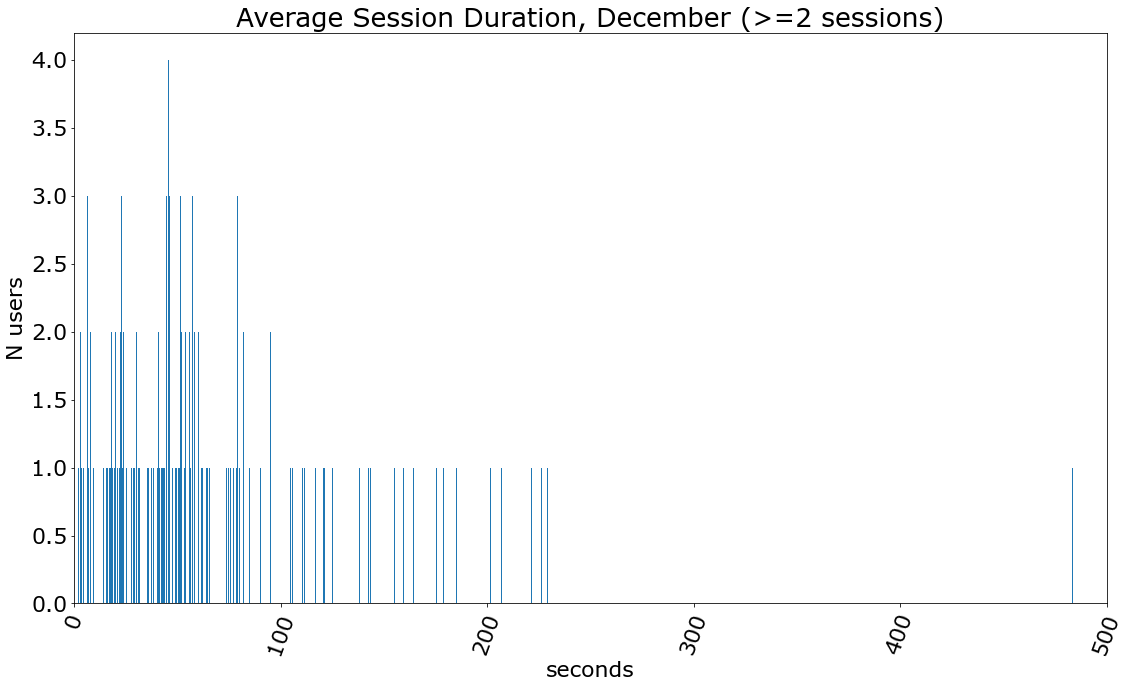

In [351]:

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

font = {'family' : 'verdana',
       # 'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)

plt.hist(dout[dout.n_sessions>=2]['avg_session_len'],bins=3000)
plt.xlim(0, 500)
plt.xticks(rotation=70)
plt.title('Average Session Duration, December (>=2 sessions)')
plt.xlabel('seconds')
plt.ylabel('N users')

plt.savefig('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/session_length.jpg')

plt.show()

In [352]:
len(dout[dout.n_sessions>=2])

282

In [183]:
len(ddd)

231

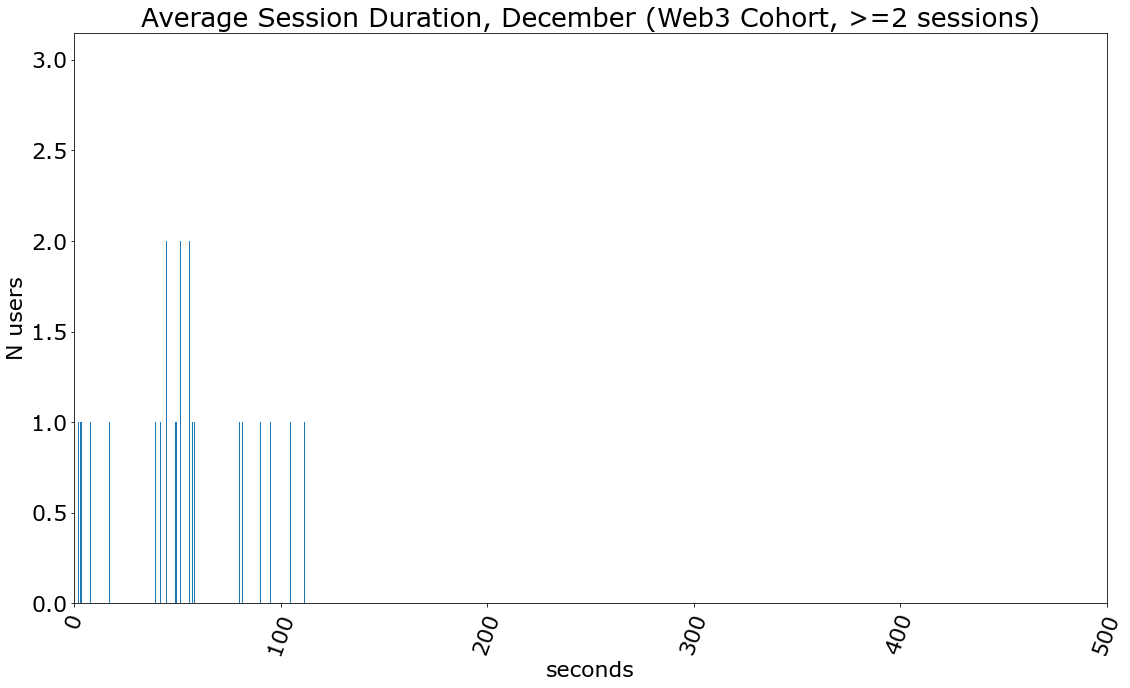

In [353]:
# ddd = dout[dout.n_sessions>=2]
# ddd[ddd['$user_id'].isin(wallet_users) ]

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

font = {'family' : 'verdana',
       # 'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)

plt.hist(ddd[ddd.n_sessions>=2]['avg_session_len'],bins=3000)
plt.xlim(0, 500)
plt.xticks(rotation=70)
plt.title('Average Session Duration, December (Web3 Cohort, >=2 sessions)')
plt.xlabel('seconds')
plt.ylabel('N users')

plt.savefig('/Users/allen/Desktop/clo/flickplay/mixpanel-events/data/Web3-Cohort-session_length.jpg')

plt.show()

In [239]:
# Total MAU:
# # 5>min Users:
# Average session:
# # <5min Users:
# Average session:

In [354]:


cutoff = 5*60 # 5 min 

dx = dout[dout.n_sessions>=0].copy()
total_n_sess = sum(dout.n_sessions)
print(f'Total MAU: {len(dout)} Users, {total_n_sess} sessions')
long = dx[dx.avg_session_len>=cutoff]
short = dx[dx.avg_session_len<cutoff]

print(f'\n>5min Users:','\n', f'\t{len(long)} users, {round(len(long)/len(dx)*100,1)}% of total MAU.')

lsum = 0
lsess_sum = 0
for idx, row in long.iterrows():
    lsum+=row.n_sessions*row.avg_session_len 
    lsess_sum+=row.n_sessions
    
print('\tAverage session duration:',round(lsum/sum(long.n_sessions),1), 'seconds')
print(f'\tNumber of sessions:{lsess_sum} sessions, {round(lsess_sum/total_n_sess*100,1)}% of total sessions')

print(f'<5min Users:','\n', f'\t{len(short)} users,{round(len(short)/len(dx)*100,1)}% of total MAU.')

ssum = 0
ssess_sum=0
for idx, row in short.iterrows():
    ssum+=row.n_sessions*row.avg_session_len 
    ssess_sum+=row.n_sessions
print('\tAverage session duration:',round(ssum/sum(short.n_sessions),1), 'seconds')
print(f'\tNumber of sessions: {ssess_sum} sessions, {round(ssess_sum/total_n_sess*100,1)}% of total sessions')


Total MAU: 441 Users, 7739 sessions

>5min Users: 
 	13 users, 2.9% of total MAU.
	Average session duration: 490.8 seconds
	Number of sessions:23 sessions, 0.3% of total sessions
<5min Users: 
 	428 users,97.1% of total MAU.
	Average session duration: 64.3 seconds
	Number of sessions: 7716 sessions, 99.7% of total sessions


In [241]:
# Total MAU:
# # Web3 Users:
# Average session:
# # Other Users:
# Average session:

db = get_mongo_db_obj()

wallet_users = [ str(w['user']) for w in db.wallets.find() ]


dw = dout[dout.n_sessions>=0].copy()
total_n_sess = sum(dout.n_sessions)
print(f'Total MAU: {len(dout)} Users, {total_n_sess} sessions')
w3 = dw[dw['$user_id'].isin(wallet_users)]
nw3 = dw[~dw['$user_id'].isin(wallet_users)]

print(f'\nWeb3 Cohort:','\n', f'\t{len(w3)} users, {round(len(w3)/len(dw)*100,1)}% of total MAU.')

lsum = 0
lsess_sum = 0
for idx, row in w3.iterrows():
    lsum+=row.n_sessions*row.avg_session_len 
    lsess_sum+=row.n_sessions
    
print('\tAverage session duration:',round(lsum/sum(w3.n_sessions),1), 'seconds')
print(f'\tNumber of sessions:{lsess_sum} sessions, {round(lsess_sum/total_n_sess*100,1)}% of total sessions')

print(f'\nNon-Web3 Cohort:','\n', f'\t{len(nw3)} users,{round(len(nw3)/len(dw)*100,1)}% of total MAU.')

ssum = 0
ssess_sum=0
for idx, row in nw3.iterrows():
    ssum+=row.n_sessions*row.avg_session_len 
    ssess_sum+=row.n_sessions
print('\tAverage session duration:',round(ssum/sum(nw3.n_sessions),1), 'seconds')
print(f'\tNumber of sessions: {ssess_sum} sessions, {round(ssess_sum/total_n_sess*100,1)}% of total sessions')



Total MAU: 320 Users, 5756 sessions

Web3 Cohort: 
 	113 users, 35.3% of total MAU.
	Average session duration: 391.7 seconds
	Number of sessions:4108 sessions, 71.4% of total sessions

Non-Web3 Cohort: 
 	207 users,64.7% of total MAU.
	Average session duration: 987.9 seconds
	Number of sessions: 1648 sessions, 28.6% of total sessions


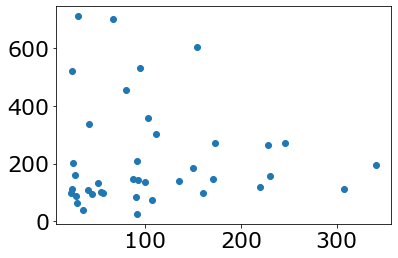

In [262]:
# d = dout[dout.avg_session_len <= 1000]
d = d[d.n_sessions>10]

xs = d['n_sessions'].values
ys = d['avg_session_len'].values

X = [ _ for _ in xs ]
logX = [  np.log(_) for _ in X ]
y = [ _ for _ in ys ]
logy = [ np.log(_) for _ in y ]

plt.scatter(X, y)

In [357]:
total_time = []


for idx, row in dout.iterrows():
    total_time.append(row.n_sessions*row.avg_session_len)
    
dout['screen_time_hr'] = [ round(x/60**2,1) for x in total_time ]
dout.sort_values(by='screen_time_hr', ascending=False)

,$user_id,n_sessions,avg_session_len,screen_time_hr
2,6293081e82c92e0a0ca0fd92,296,142.4,11.7
4,62c7adc4b8deb3d981f8b8bc,292,95.0,7.7
0,609d510c4244340b2a77c83a,366,63.7,6.5
11,6262b5ce801ba557543ac90a,184,120.6,6.2
5,62a1e07c309538d8a0a774ce,287,75.7,6.0
7,62bf3b0b1cc78f2ab79f7479,250,78.9,5.5
17,62d2778ac412cd75e151c01d,129,134.0,4.8
3,63316470d7d49d45584ccc5e,294,53.7,4.4
1,637563bedf033a9580c865d7,352,43.1,4.2
8,629fd04337d60d14998feff0,245,57.1,3.9


In [338]:


cutoff = 5*60 # 5 min 

dx = d.copy()#dout[dout.n_sessions>=0].copy()
total_n_sess = sum(dout.n_sessions)
print(f'Total MAU: {len(dout)} Users, {total_n_sess} sessions, {round(sum(dx.screen_time_hr),1)} hours')
long = dx[dx.avg_session_len>=cutoff]
short = dx[dx.avg_session_len<cutoff]
total_screen_time = sum(dx.screen_time_hr)

print(f'\n>5min Users:','\n', f'\t{len(long)} users, {round(len(long)/len(dx)*100,1)}% of total MAU.')

lsum = 0
lsess_sum = 0
for idx, row in long.iterrows():
    lsum+=row.n_sessions*row.avg_session_len 
    lsess_sum+=row.n_sessions
    
print('\tAverage session duration:',round(lsum/sum(long.n_sessions),1), 'seconds')
print('\tAverage number of sessions:', round(long.n_sessions.mean(),1), 'sessions')
print('\tAverage screen time:', round(long.screen_time_hr.mean(),1), 'hours')
print(f'\tTotal Number of sessions: {lsess_sum} sessions, {round(lsess_sum/total_n_sess*100,1)}% of total sessions')
print(f'\tTotal screen time:', round(sum(long.screen_time_hr),1) , 'hours', f'{round(sum(long.screen_time_hr)/total_screen_time*100,1)}% of the total {round(total_screen_time,1)} hours.')
print()
print(long.describe())

print('='*80)
print()
print(f'<5min Users:','\n', f'\t{len(short)} users, {round(len(short)/len(dx)*100,1)}% of total MAU.')
ssum = 0
ssess_sum=0
sess_total_time=0

for idx, row in short.iterrows():
    ssum+=row.n_sessions*row.avg_session_len 
    ssess_sum+=row.n_sessions
print('\tAverage session duration:',round(ssum/sum(short.n_sessions),1), 'seconds')
print('\tAverage number of sessions:', round(short.n_sessions.mean(),1), 'sessions')
print('\tAverage screen time:', round(short.screen_time_hr.mean(),1), 'hours')
print(f'\tNumber of sessions: {ssess_sum} sessions, {round(ssess_sum/total_n_sess*100,1)}% of total sessions')
print(f'\tTotal screen time:', round(sum(short.screen_time_hr),1) , 'hours', f'{round(sum(short.screen_time_hr)/total_screen_time*100,1)}% of the total {round(total_screen_time,1)} hours.')
print()
print(short.describe())

# Total MAU:
# # Web3 Users:
# Average session:
# # Other Users:
# Average session:

db = get_mongo_db_obj()

wallet_users = [ str(w['user']) for w in db.wallets.find() ]


dw = dout[dout.n_sessions>=0].copy()
total_n_sess = sum(dout.n_sessions)
print(f'Total MAU: {len(dout)} Users, {total_n_sess} sessions, {round(sum(dw.screen_time_hr),1)} hours')
w3 = dw[dw['$user_id'].isin(wallet_users)]
nw3 = dw[~dw['$user_id'].isin(wallet_users)]
total_screen_time = sum(dw.screen_time_hr)

print(f'\nWeb3 Cohort:','\n', f'\t{len(w3)} users, {round(len(w3)/len(dw)*100,1)}% of total MAU')
print(f'{round(sum(w3.screen_time_hr),1)} hours, {round(sum(dw.screen_time_hr)/sum(dw.screen_time_hr)*100,1)}% of total {round(sum(dw.screen_time_hr),1)} hours')

lsum = 0
lsess_sum = 0
for idx, row in w3.iterrows():
    lsum+=row.n_sessions*row.avg_session_len 
    lsess_sum+=row.n_sessions
    
# print('\tAverage session duration:',round(lsum/sum(w3.n_sessions),1), 'seconds')
# print(f'\tNumber of sessions:{lsess_sum} sessions, {round(lsess_sum/total_n_sess*100,1)}% of total sessions')
long,short=w3,nw3
print('\tAverage session duration:',round(lsum/sum(long.n_sessions),1), 'seconds')
print('\tAverage number of sessions:', round(long.n_sessions.mean(),1), 'sessions')
print('\tAverage screen time:', round(long.screen_time_hr.mean(),1), 'hours')
print(f'\tTotal Number of sessions: {lsess_sum} sessions, {round(lsess_sum/total_n_sess*100,1)}% of total sessions')
print(f'\tTotal screen time:', round(sum(long.screen_time_hr),1) , 'hours', f'{round(sum(long.screen_time_hr)/total_screen_time*100,1)}% of the total {round(total_screen_time,1)} hours.')
print()
print(long.describe().T)
print()
print(f'\nNon-Web3 Cohort:','\n', f'\t{len(nw3)} users,{round(len(nw3)/len(dw)*100,1)}% of total MAU.')

ssum = 0
ssess_sum=0
for idx, row in nw3.iterrows():
    ssum+=row.n_sessions*row.avg_session_len 
    ssess_sum+=row.n_sessions
print('\tAverage session duration:',round(ssum/sum(short.n_sessions),1), 'seconds')
print('\tAverage number of sessions:', round(short.n_sessions.mean(),1), 'sessions')
print('\tAverage screen time:', round(short.screen_time_hr.mean(),1), 'hours')
print(f'\tNumber of sessions: {ssess_sum} sessions, {round(ssess_sum/total_n_sess*100,1)}% of total sessions')
print(f'\tTotal screen time:', round(sum(short.screen_time_hr),1) , 'hours', f'{round(sum(short.screen_time_hr)/total_screen_time*100,1)}% of the total {round(total_screen_time,1)} hours.')
print()
print(short.describe().T)



Total MAU: 320 Users, 5756 sessions, 550.7 hours

>5min Users: 
 	32 users, 27.1% of total MAU.
	Average session duration: 1017.1 seconds
	Average number of sessions: 42.4 sessions
	Average screen time: 12.0 hours
	Total Number of sessions: 1357 sessions, 23.6% of total sessions
	Total screen time: 383.3 hours 69.6% of the total 550.7 hours.

       n_sessions  avg_session_len  screen_time_hr
count   32.000000        32.000000       32.000000
mean    42.406250      1641.928125       11.978125
std     46.687609      1535.723357       12.443076
min      5.000000       303.200000        0.900000
25%      8.750000       527.625000        3.350000
50%     20.500000      1025.850000        8.800000
75%     65.250000      2154.375000       14.350000
max    189.000000      6160.800000       54.300000

<5min Users: 
 	86 users, 72.9% of total MAU.
	Average session duration: 150.9 seconds
	Average number of sessions: 46.5 sessions
	Average screen time: 1.9 hours
	Number of sessions: 3995 session

In [326]:
short.describe()

,n_sessions,avg_session_len,screen_time_hr
count,86.000000,86.000000,86.000000
mean,46.453488,111.788372,1.946512
std,72.890515,62.729785,3.919865
min,5.000000,7.500000,0.000000
25%,7.000000,69.000000,0.200000
50%,12.000000,99.700000,0.400000
75%,43.750000,145.725000,1.200000
max,341.000000,291.400000,18.500000


In [ ]:
long.describe()

In [335]:
# % of users who have N or fewer sessions

n_pops = dict() # population of users who have (key) number of sessions in november
n_session_max = max(dout.n_sessions)
n_total_sesh = sum(dout.n_sessions)

print(n_session_max)
print(n_total_sesh)

for n in range(1,500):
    N_users = len(dout[dout.n_sessions==n])
    if N_users == 0:
        continue
    n_pops[n] = N_users
    user_pct = round(N_users/len(dout)*100,1)
    sesh_pct = round(N_users*n/n_total_sesh*100,1)
    print(f'{N_users} users have {n} sessions, \n\t{user_pct}% of the total {len(dout)} MAU \t\t{sesh_pct}% of the {total_n_sess} sessions.')

341
5756
89 users have 1 sessions, 
	27.8% of the total 320 MAU 		1.5% of the 5756 sessions.
50 users have 2 sessions, 
	15.6% of the total 320 MAU 		1.7% of the 5756 sessions.
37 users have 3 sessions, 
	11.6% of the total 320 MAU 		1.9% of the 5756 sessions.
26 users have 4 sessions, 
	8.1% of the total 320 MAU 		1.8% of the 5756 sessions.
12 users have 5 sessions, 
	3.8% of the total 320 MAU 		1.0% of the 5756 sessions.
14 users have 6 sessions, 
	4.4% of the total 320 MAU 		1.5% of the 5756 sessions.
6 users have 7 sessions, 
	1.9% of the total 320 MAU 		0.7% of the 5756 sessions.
6 users have 8 sessions, 
	1.9% of the total 320 MAU 		0.8% of the 5756 sessions.
7 users have 9 sessions, 
	2.2% of the total 320 MAU 		1.1% of the 5756 sessions.
4 users have 10 sessions, 
	1.2% of the total 320 MAU 		0.7% of the 5756 sessions.
3 users have 11 sessions, 
	0.9% of the total 320 MAU 		0.6% of the 5756 sessions.
6 users have 12 sessions, 
	1.9% of the total 320 MAU 		1.3% of the 5756 sessi

In [312]:
d = dout[dout.n_sessions>=5]

d.sort_values(by='screen_time_hr', ascending=0)
d[d['$user_id']=='637563bedf033a9580c865d7']

,$user_id,n_sessions,avg_session_len,screen_time_hr
1,637563bedf033a9580c865d7,308,111.7,9.6


(1.0, 40.0)

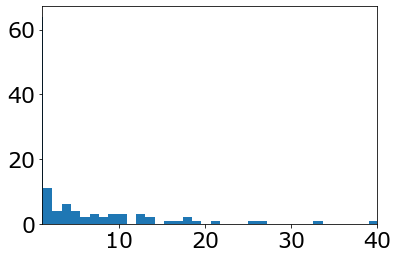

In [306]:
plt.hist(d.screen_time_hr, bins=50)
# plt.ylim(0,50)
plt.xlim(1,40)

In [311]:
list(db.users.find({'username': 'emmamonroe'}))

[{'_id': ObjectId('637563bedf033a9580c865d7'),
  'profileImage': {'name': None,
   'path': 'users/637563bedf033a9580c865d7/images/3227f5eb36b14627bd89d41ce49798b6.webp',
   'type': 'image/webp',
   'size': 9816},
  'googleId': None,
  'facebookId': None,
  'email': '',
  'name': '',
  'age': -1,
  'gender': '',
  'bio': '',
  'countryCode': '+1',
  'phone': '2064667960',
  'phoneHash': '7d96912d617b933c7198fcf25e3d7bdf16f3eda6ece9b277cb03fdfe14aa4cc7',
  'role': 'user',
  'isUser': True,
  'isAdmin': False,
  'isMapCreator': False,
  'isMapCreatorDelete': False,
  'loginCount': 0,
  'deleted': False,
  'active': False,
  'verified': True,
  'mapThumbnail': 'users/637563bedf033a9580c865d7/mapThumbnail/1891eb4206f54d7d9b3df2a3532ba9b7.png',
  'lastSpotRecordingId': '63a3c66bd16b60035bdac283',
  'profileCover': 'users/637563bedf033a9580c865d7/profileCover/51570a8906e54bc1a9bf920c4951ff90.webp',
  'profileCoverV2': None,
  'profileCoverVideoId': None,
  'profileCoverOffsetMultiplier': None